In [1]:
import pandas as pd
import json
import ast

# Data with Entities

In [2]:
df = pd.read_csv(r'/Users/shantanupatankar/Desktop/Social Computing Project/Data/Clean Data/relevant_data_trim_entities_6.csv')

In [3]:
# Count the number of authors with more than 1 tweet
author_counts = df['author_id'].value_counts()
authors_with_multiple_tweets = (author_counts > 10).sum()

print(f"Number of authors with more than 1 tweet: {authors_with_multiple_tweets}")
print(f"Total unique authors: {len(author_counts)}")
print(f"Percentage of authors with >1 tweet: {authors_with_multiple_tweets/len(author_counts)*100:.2f}%")

Number of authors with more than 1 tweet: 180114
Total unique authors: 312538
Percentage of authors with >1 tweet: 57.63%


In [4]:
import pandas as pd
import ast

def process_dataframe(df):
    """
    Analyzes tweet data from a DataFrame and returns user-level aggregated metrics.
    
    Parameters:
    df (pd.DataFrame): A DataFrame with tweet data. Must include 'entities', 'text',
                       'created_at', 'public_metrics', 'author_id', and 'id' columns.
    
    Returns:
    pd.DataFrame: Aggregated metrics per user (author_id).
    """

    # Convert 'entities' to dictionaries if they're strings
    if isinstance(df['entities'].iloc[0], str):
        try:
            df['entities'] = df['entities'].apply(ast.literal_eval)
        except:
            pass

        # Extract entity counts
        

    try:
        df['hashtags_count'] = df['entities'].apply(lambda x: len(x['hashtags']))
    except:
        df['hashtags_count'] = 0

    try:
        df['symbols_count'] = df['entities'].apply(lambda x: len(x['symbols']))
    except:
        df['symbols_count'] = 0

    try:
        df['user_mentions_count'] = df['entities'].apply(lambda x: len(x['user_mentions']))
    except:
        df['user_mentions_count'] = 0

    try:
        df['urls_count'] = df['entities'].apply(lambda x: len(x['urls']))
    except:
        df['urls_count'] = 0

    try:
        df['media_count'] = df['entities'].apply(lambda x: len(x.get('media', [])))
    except:
        df['media_count'] = 0

    try:
        df['word_count'] = df['text'].apply(lambda x: len(x.split()))
    except:
        df['word_count'] = 0

    # Ensure 'created_at' is in datetime format
    df['created_at'] = pd.to_datetime(df['created_at'])

    # Convert 'public_metrics' to dict if it's a string
    try:
        df['public_metrics'] = df['public_metrics'].apply(ast.literal_eval)
    except:
        pass  # Already in dictionary format

    def safe_get_metrics(metrics, field):
        try:
            if isinstance(metrics, dict):
                return metrics.get(field, 0)
            return 0
        except:
            return 0

    df['retweet_count'] = df['public_metrics'].apply(lambda x: safe_get_metrics(x, 'retweet_count'))
    df['reply_count'] = df['public_metrics'].apply(lambda x: safe_get_metrics(x, 'reply_count'))
    df['like_count'] = df['public_metrics'].apply(lambda x: safe_get_metrics(x, 'like_count'))
    df['quote_count'] = df['public_metrics'].apply(lambda x: safe_get_metrics(x, 'quote_count'))

    # Sort by author and time
    df_sorted = df.sort_values(['author_id', 'created_at'])

    # Calculate time differences between tweets
    df_sorted['time_diff'] = df_sorted.groupby('author_id')['created_at'].diff().dt.total_seconds()

    # Group by author and compute aggregated metrics
    result_df = (
        df_sorted
        .groupby('author_id')
        .agg(
            median_time_between_tweets_seconds=('time_diff', 'median'),
            tweet_count=('id', 'count'),
            avg_retweet_count=('retweet_count', 'mean'),
            avg_reply_count=('reply_count', 'mean'),
            avg_like_count=('like_count', 'mean'),
            avg_quote_count=('quote_count', 'mean'),
            avg_hashtag_count=('hashtags_count', 'mean'),
            avg_symbols_count=('symbols_count', 'mean'),
            avg_user_mentions_count=('user_mentions_count', 'mean'),
            avg_media_count=('media_count', 'mean'),
            avg_word_count=('word_count', 'mean'),
        )
        .reset_index()
    )

    # Add time in minutes and hours
    result_df['median_time_between_tweets_minutes'] = result_df['median_time_between_tweets_seconds'] / 60
    result_df['median_time_between_tweets_hours'] = result_df['median_time_between_tweets_seconds'] / 3600

    # Drop users with only 1 tweet (NaN median time)
    result_df = result_df.dropna(subset=['median_time_between_tweets_seconds'])

    # Round select metrics for readability
    round_cols = ['avg_retweet_count', 'avg_reply_count', 'avg_like_count', 'avg_quote_count']
    result_df[round_cols] = result_df[round_cols].round(2)

    return result_df


In [5]:
result_df = process_dataframe(df)

In [6]:
result_df['author_id'] = 'u' + result_df['author_id'].astype(str)

In [7]:
label_df = pd.read_csv("/Users/shantanupatankar/Desktop/Social Computing Project/Data/Raw Data/label.csv")
result_df = result_df.merge(label_df, left_on='author_id', right_on='id', how='left')


In [8]:
result_df.to_csv("/Users/shantanupatankar/Desktop/Social Computing Project/Data/Clean Data/Tweet_Numerical_6.csv", index = False)

In [9]:
# result_df = result_df[result_df['tweet_count'] > 10]

In [10]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import make_pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import numpy as np

def train_model(data):
    # Encode the target variable
    le = LabelEncoder()
    data['label'] = le.fit_transform(data['label'])
    
    # Separate features and target
    cols_to_drop = ['label', 'author_id', 'id', 'id_x', 'id_y']
    X = data.drop(columns=[col for col in cols_to_drop if col in data.columns])
    y = data['label']
    
    # Handle missing values (NaN)
    X = X.fillna(0)  # Or use more sophisticated imputation
    
    # Split data (stratified to maintain class distribution in splits)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, 
        test_size=0.1, 
        random_state=42, 
        stratify=y
    )
    
    # Create undersampler - reduces majority class to match minority
    undersampler = RandomUnderSampler(
        sampling_strategy='auto',  # balances the classes
        random_state=42
    )
    
    # Create model with balanced class weights
    model = RandomForestClassifier(
        class_weight='balanced',
        random_state=42,
        n_estimators=200,
        max_depth=30
    )
    
    # Create a pipeline that first undersamples then fits the model
    pipeline = make_pipeline(undersampler, model)
    
    # Fit the pipeline (undersampling happens during fit, not on test data)
    pipeline.fit(X_train, y_train)
    
    return model, X_train, X_test, y_train, y_test

# Tweet Features

In [11]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

def evaluate(model,X_test,y_test):
    # Predictions
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    
    # Evaluation metrics
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    print("\nROC AUC Score:", roc_auc_score(y_test, y_proba))

In [12]:
import matplotlib.pyplot as plt

# Plot feature importance
def print_feature_importance(model, X):
    plt.figure(figsize=(10, 8))
    sorted_idx = model.feature_importances_.argsort()
    plt.barh(X.columns[sorted_idx], model.feature_importances_[sorted_idx])
    plt.xlabel("XGBoost Feature Importance")
    plt.show()

Confusion Matrix:
[[ 1522   871]
 [ 8811 15470]]

Classification Report:
              precision    recall  f1-score   support

           0       0.15      0.64      0.24      2393
           1       0.95      0.64      0.76     24281

    accuracy                           0.64     26674
   macro avg       0.55      0.64      0.50     26674
weighted avg       0.87      0.64      0.71     26674


ROC AUC Score: 0.6930334299966407


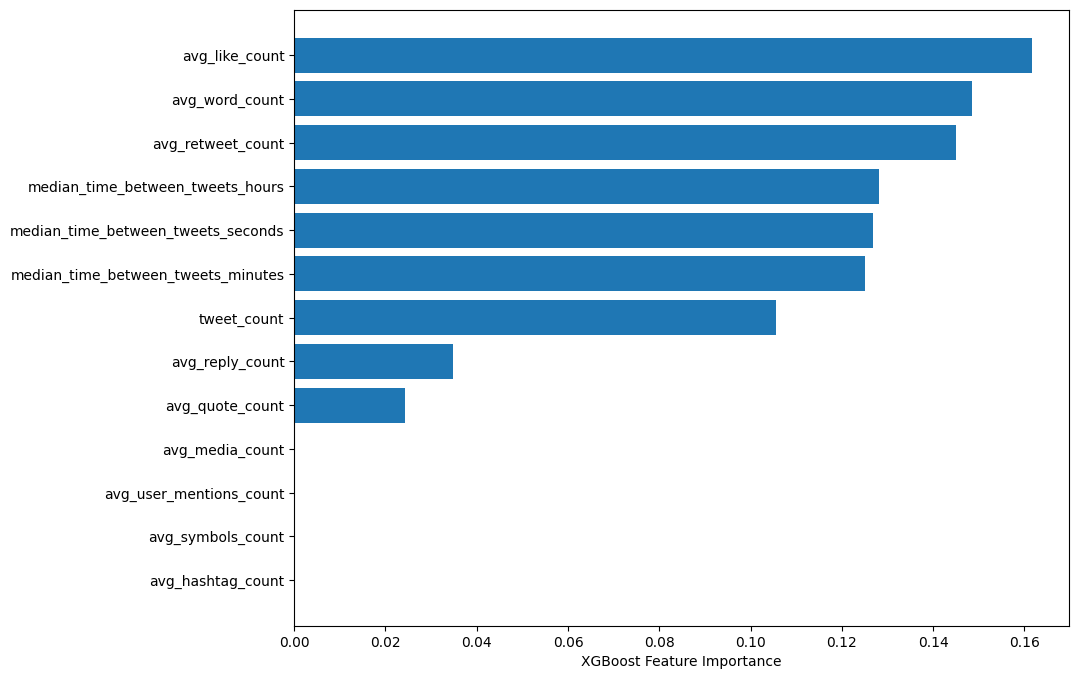

In [13]:
model, X_train, X_test, y_train, y_test = train_model(result_df)
evaluate(model,X_test,y_test)
print_feature_importance(model, X_train)

# Tweet + User Features

In [14]:
import pandas as pd
import ast

def prepare_user_data(df_users, df_tweets):

    # Parse the 'public_metrics' JSON-like column into separate columns
    def public_metrics_col(df):
        col_names = list(ast.literal_eval(df['public_metrics'].iloc[0]).keys())
        final_cols = []
        for i in range(len(df)):
            dic = ast.literal_eval(df['public_metrics'].iloc[i])
            final_cols.append(list(dic.values()))
        metrics_df = pd.DataFrame(final_cols, columns=col_names)
        df = pd.concat([df.reset_index(drop=True), metrics_df], axis=1)
        return df

    df_users = public_metrics_col(df_users)
    print(len(df_users))

    # Add description length feature
    df_users['description_len'] = df_users['description'].apply(lambda x: len(str(x)))
    
    # Select useful features
    useful_user_features = [
        "description_len", "id", "name", "protected", "followers_count",
        "following_count", "tweet_count", "listed_count", "username", "verified"
    ]
    df_users_features = df_users[useful_user_features]
    print(len(df_users_features))
    # Match users from tweet authors
    users = set([str(i) for i in df_tweets['author_id'].unique()])
    df_data = df_users_features[df_users_features['id'].isin(users)].reset_index(drop=True)
    print(len(df_data))
    # Binary encode booleans
    df_data['protected'] = df_data['protected'].apply(lambda x: 1 if x is True else 0)
    df_data['verified'] = df_data['verified'].apply(lambda x: 1 if x is True else 0)

    # Final feature selection
    df_data = df_data[[
        'description_len', 'protected', 'followers_count', 'following_count',
        'tweet_count', 'listed_count', 'verified', 'id'
    ]]

    return df_data


In [15]:
df_users = pd.read_csv("/Users/shantanupatankar/Desktop/Social Computing Project/Data/Raw Data/users.csv")
# processed_user_data = prepare_user_data(df_users, result_df)

/var/folders/jr/zkdlkh_92dz8sgd8xw34xn7h0000gn/T/ipykernel_18015/2460562147.py:1: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  df_users = pd.read_csv("/Users/shantanupatankar/Desktop/Social Computing Project/Data/Raw Data/users.csv")


In [16]:
processed_user_data = prepare_user_data(df_users, result_df)

1000000
1000000
266735


In [17]:
processed_user_data

,description_len,protected,followers_count,following_count,tweet_count,listed_count,verified,id
0,92,0,7316,215,3098,69,0,u1217628182611927040
1,91,0,161,278,788,0,0,u1519144464
2,81,0,10299,2166,57397,383,1,u15211869
3,26,0,45541,1206,9194,605,0,u2465283662
4,149,0,4694,4739,91381,116,0,u234059290
...,...,...,...,...,...,...,...,...
266730,44,0,174,105,12619,2,0,u1380005641863917569
266731,127,0,1935,551,8924,61,0,u98572807
266732,121,0,76,20,107,2,0,u706703037973147652
266733,157,0,2550,2515,77886,60,0,u16481893


In [18]:
result_df_merged = result_df.merge(processed_user_data, left_on='author_id', right_on='id', how='left')



In [19]:
result_df['author_id'].unique()

array(['u12', 'u17', 'u22', ..., 'u1495621436387610626',
       'u1495808636400115720', 'u1495884505630007299'],
      shape=(266735,), dtype=object)

Confusion Matrix:
[[ 1854   539]
 [ 5655 18626]]

Classification Report:
              precision    recall  f1-score   support

           0       0.25      0.77      0.37      2393
           1       0.97      0.77      0.86     24281

    accuracy                           0.77     26674
   macro avg       0.61      0.77      0.62     26674
weighted avg       0.91      0.77      0.81     26674


ROC AUC Score: 0.8528549878457639


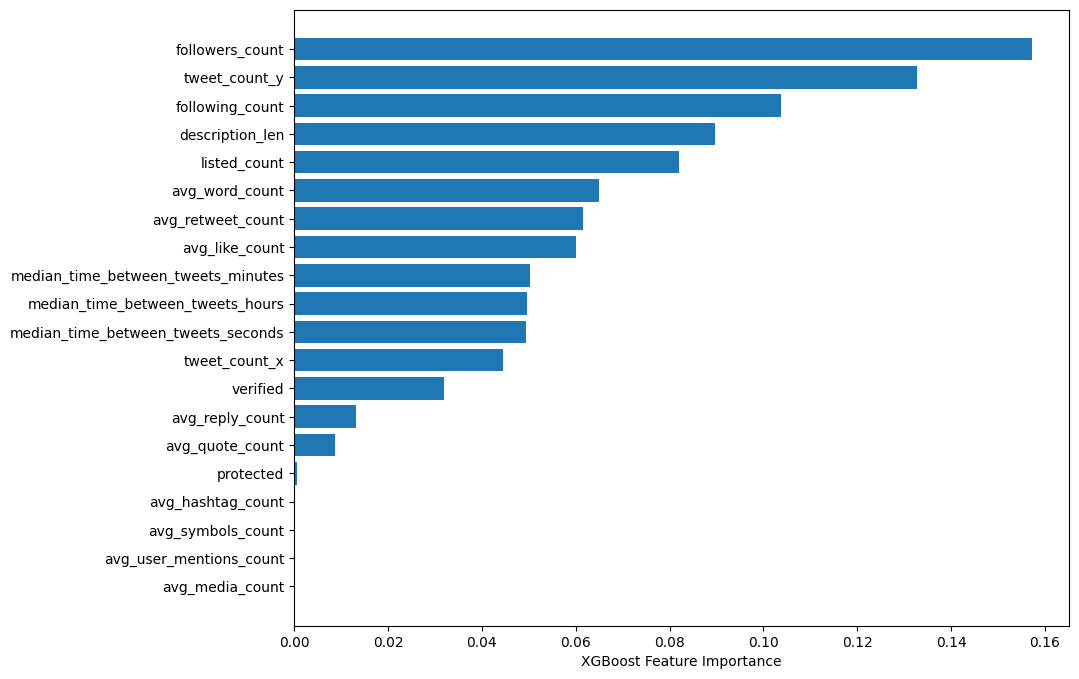

In [20]:
model, X_train, X_test, y_train, y_test = train_model(result_df_merged)

evaluate(model,X_test,y_test)
print_feature_importance(model, X_train)

In [21]:
result_df_merged.to_csv("/Users/shantanupatankar/Desktop/Social Computing Project/Data/Clean Data/Tweet_User_Numerical_6.csv", index = False)

In [3]:
import pandas as pd
df0 = pd.read_csv("/Users/shantanupatankar/Desktop/Social Computing Project/Data/Clean Data/relevant_data_trim_entities_0.csv",usecols=['text', 'author_id'])
df2 = pd.read_csv("/Users/shantanupatankar/Desktop/Social Computing Project/Data/Clean Data/relevant_data_trim_entities_2.csv",usecols=['text', 'author_id'])
df6 = pd.read_csv("/Users/shantanupatankar/Desktop/Social Computing Project/Data/Clean Data/relevant_data_trim_entities_6.csv",usecols=['text', 'author_id'])

In [4]:
df_merged = pd.concat([df0,df2,df6])

In [10]:
cols = pd.read_csv("/Users/shantanupatankar/Desktop/Social Computing Project/Data/Clean Data/Tweets_balanced.csv").author_id
df_lab = pd.read_csv("/Users/shantanupatankar/Desktop/Social Computing Project/Data/Raw Data/label.csv")

In [13]:
cols = pd.read_csv("/Users/shantanupatankar/Desktop/Social Computing Project/Data/Clean Data/Tweets_balanced.csv").author_id
df_merged['author_id'] = df_merged['author_id'].apply(lambda x: 'u' + str(x))
df_merged = df_merged[df_merged['author_id'].isin(cols)]

In [16]:
df_merged = df_merged.reset_index(drop=True)


In [19]:
# Group by author_id and take first 5 tweets per author
grouped = df_merged.groupby('author_id')['text'].apply(lambda x: x.head(5).reset_index(drop=True))

# Function to concatenate with markers
def concat_with_markers(tweets):
    return ' '.join([f"{tweet} [{i+1}]" for i, tweet in enumerate(tweets)])

# Apply the function to each group
result_df = grouped.groupby(level=0).apply(concat_with_markers).reset_index(name='text')


In [20]:
len(result_df)

93276

In [21]:
len(cols)

93276

In [27]:
# Rename 'id' to 'author_id' in df_lab for the merge
df_lab_renamed = df_lab.rename(columns={'id': 'author_id'})

# Merge the dataframes on 'author_id'
final_df = pd.merge(result_df, df_lab_renamed, on='author_id', how='inner')


In [30]:
final_df.to_csv("/Users/shantanupatankar/Desktop/Social Computing Project/Data/Clean Data/Text5_balanced.csv", index = False)

In [31]:
df0

,author_id,text
0,1304855289208819713,@phaseknight_ Although I didn't base this sket...
1,1304855289208819713,"I mean, doesn't his beautiful face just scream..."
2,1304855289208819713,"@Cobalt_han I'm British, so that used to be me..."
3,1304855289208819713,RT @itsginnydi: the only thing better than the...
4,1304855289208819713,"Lucky and his sister, among other bears, were ..."
...,...,...
7326592,16989141,RT @scotgov: The less we judge people struggli...
7326593,16989141,@BertNodules @Lenniesaurus We* the taxpayers o...
7326594,16989141,RT @choochod: Cast a vote for Dave.
7326595,16989141,"RT @neilmosley5: ""As more and more employers a..."
